In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

%matplotlib inline

In [2]:
import xml.etree.ElementTree as ET


def get_diagnosis(fillename: str) -> None:
    root = ET.parse(filename).getroot()
    # node = root
    # for i, e in enumerate(node):
    #     print(i, "\t", e)

    print("Diagnosis:", "\n")

    node = root[6]

    for i in node:
        if i.tag == "DiagnosisStatement":
            for j in i:
                if j.tag == "StmtText":
                    print(j.text)

In [3]:
def plot_ecg(X):
    leads = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
    for c in range(12):
        plt.figure(figsize=(20, 5))
        plt.plot(X[:, c])
        plt.title(leads[c])
        plt.grid()

    plt.show()

In [4]:
data = [
    pd.read_csv(f"data/patient_{i}.csv").drop(columns="Unnamed: 12") for i in [1, 2]
]

In [5]:
X = scipy.signal.resample(data, 4000, axis=-2)[...]
X = np.pad(X, ((0, 0), (48, 48), (0, 0)), "constant")
X = X / 100
print(X.shape)

(2, 4096, 12)


In [9]:
# plot_ecg(X[0])

In [7]:
from keras.models import load_model
from keras.optimizers import Adam

model = load_model("model/model.hdf5", compile=False)
model.compile(loss="binary_crossentropy", optimizer=Adam())

2023-01-12 10:56:34.995007: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-12 10:56:37.600053: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-12 10:56:37.601195: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
Y = model.predict(X)
print(Y)
print(Y > 0.5)

1/1 [==============================] - 0s 274ms/step
[[5.0600321e-04 2.9564858e-04 8.2674196e-05 9.6254404e-08 6.3298506e-01
  1.3814695e-04]
 [6.0870657e-06 1.3384314e-07 4.8042050e-09 9.6219708e-08 1.5358246e-08
  3.4617647e-06]]
[[False False False False  True False]
 [False False False False False False]]


In [10]:
import lime
import lime.lime_tabular

In [13]:
X_lime = X.reshape((2, -1))

In [14]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_lime)

In [18]:
def lime_predict(X):
    return model.predict(X.reshape((-1, 4096, 12)))

In [19]:
exp = explainer.explain_instance(X_lime[0], lime_predict)

157/157 [==============================] - 127s 808ms/step


/users/eleves-b/2020/nhat.vo/.conda/envs/thesis/lib/python3.9/site-packages/lime/lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


In [22]:
exp.show_in_notebook()

In [30]:
X_img = np.stack((X,) * 3, axis=-1)

In [29]:
X.shape

(2, 4096, 12)

In [47]:
def predict_img(X):
    return model.predict(X[..., 0], verbose=False)

In [48]:
from lime import lime_image

explainer = lime_image.LimeImageExplainer()
exp = explainer.explain_instance(X_img[0], predict_img)

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.44it/s]


In [61]:
from skimage.segmentation import mark_boundaries
from skimage.transform import resize

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


No key 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


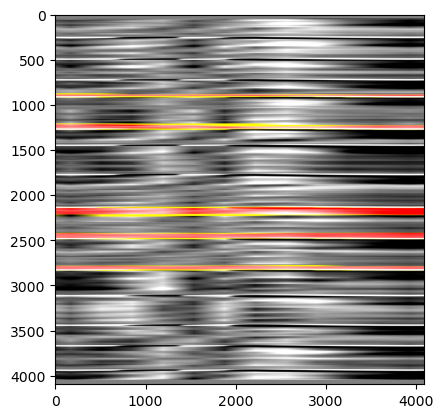

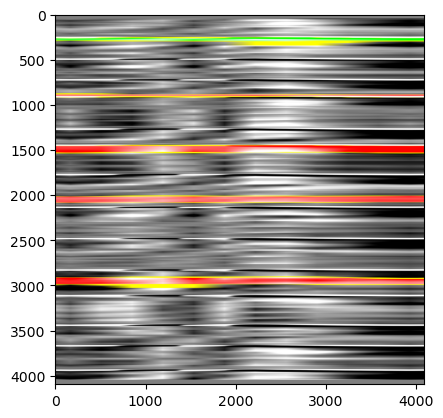

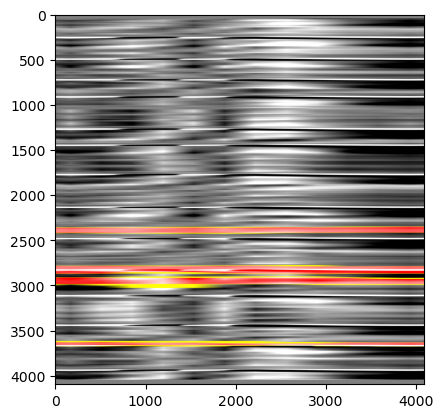

<Figure size 640x480 with 0 Axes>

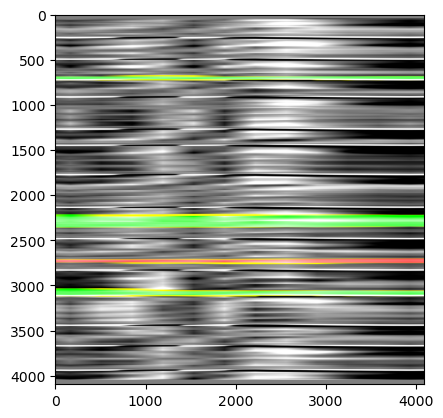

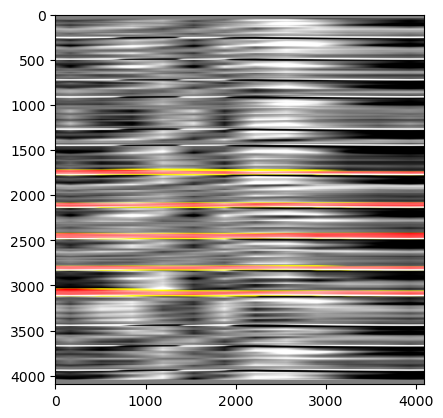

In [74]:
for i in range(6):
    plt.figure()
    try:
        temp, mask = exp.get_image_and_mask(i, positive_only=False, hide_rest=False)
        plt.imshow(resize(mark_boundaries(temp / 2 + 0.5, mask), (4096, 4092)))
    except Exception:
        print("No key", i)

plt.show()